In [202]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***Libraries and Read Data***

In [203]:
!pip install unidecode
!pip install statsmodels


In [204]:
import pandas as pd
import unidecode
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import unicodedata # Import the missing module
import statsmodels.api as sm

# Import necessary functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [205]:
df = pd.read_excel('/content/drive/My Drive/Colab Notebooks/Real_Estate_data.xlsx')
df = df.drop(columns = ['Đường',	'Phường'])
df = df[df['Loại hình'] != 'Căn hộ Studio']
df = df[df['Loại hình'] != 'Office-tel']
df = df.drop(columns = ['Loại hình', 'Số tầng', 'Hướng nhà', 'Dự án'])

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6782 entries, 0 to 6781
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Quận                6782 non-null   object
 1   Phòng ngủ           6782 non-null   int64 
 2   Phòng tắm           6782 non-null   int64 
 3   Diện tích           6782 non-null   object
 4   Tình hình nội thất  6782 non-null   object
 5   Loại chủ quyền      6538 non-null   object
 6   Tình trạng sử dụng  6782 non-null   object
 7   Giá                 6782 non-null   object
dtypes: int64(2), object(6)
memory usage: 476.9+ KB


# ***`Data Preprocessing (Area + Text + Giá)`***

In [207]:
df.fillna('unknown', inplace=True)

In [208]:
def remove_vietnamese_accents(text):
    # Normalize the text to decompose accents
    normalized_text = unicodedata.normalize('NFD', text)

    # Filter out combining diacritical marks
    text_without_accents = ''.join([char for char in normalized_text if not unicodedata.combining(char)])

    return text_without_accents

columns_to_process = ['Quận', 'Tình hình nội thất', 'Loại chủ quyền', 'Tình trạng sử dụng']
for col in columns_to_process:
    df[col] = df[col].astype(str).apply(remove_vietnamese_accents)

In [209]:
# Assuming 'df' is your DataFrame and the column is 'area'
df['Diện tích'] = df['Diện tích'].str.replace('m²', '')
df['Diện tích'] = df['Diện tích'].str.replace(',', '').astype(float)

In [210]:
def convert_to_number(val):
    val = val.lower()
    if 'tỷ' in val:
        return float(val.replace('tỷ', '').strip()) * 1000000000
    elif 'triệu' in val or 'tr' in val:
        return float(val.replace('triệu', '').replace('tr', '').strip()) * 1000000
    return float(val)

df['Giá'] = df['Giá'].astype(str).apply(convert_to_number)


# ***`Frequent Chart`***

In [211]:
df.head(2)

,Quận,Phòng ngủ,Phòng tắm,Diện tích,Tình hình nội thất,Loại chủ quyền,Tình trạng sử dụng,Giá
0,Quan 9,3,3,104.0,Đay đu noi that,So hong,Đang o,5.800000e+09
1,Quan 2,2,2,84.0,Noi that co ban,HĐ mua ban,Nha trong,1.500000e+10


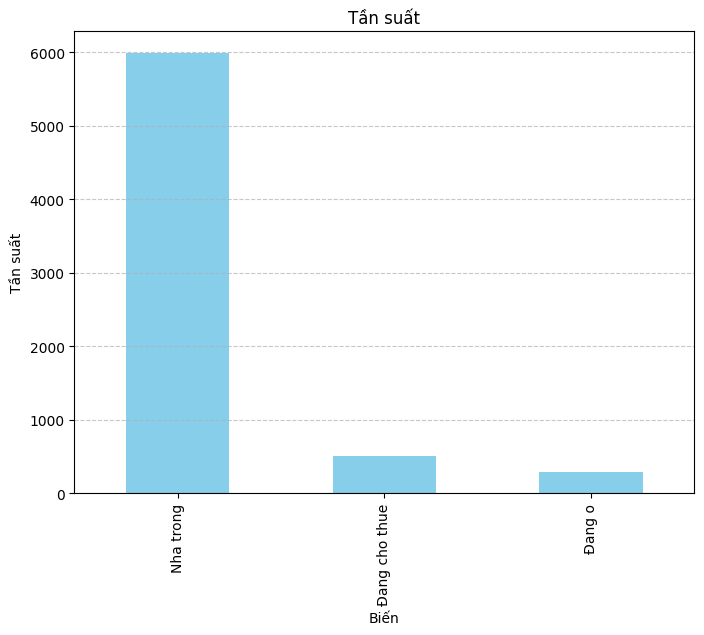

In [212]:
# Tạo biểu đồ tần suất
plt.figure(figsize=(8, 6))
df['Tình trạng sử dụng'].value_counts().sort_index().plot(kind='bar', color='skyblue')

# Thiết lập tiêu đề và nhãn
plt.title('Tần suất')
plt.xlabel('Biến')
plt.ylabel('Tần suất')
plt.xticks(rotation=90)  # Xoay nhãn trục x nếu cần
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Hiển thị biểu đồ
plt.show()

In [213]:
# # Xác định ngưỡng để nhóm các quận
# high_threshold = 1000  # Ngưỡng tần suất cao
# medium_threshold = 300  # Ngưỡng tần suất trung bình

# # Hàm để phân loại nhóm
# def quan(district):
#     # Get the frequency of the district in the original DataFrame
#     frequency = df['Quận'].value_counts()[district]

#     if frequency >= high_threshold:
#         return 'High Frequency'
#     elif frequency >= medium_threshold:
#         return 'Medium Frequency'
#     else:
#         return 'Low Frequency'

# df['Quận'] = df['Quận'].apply(quan)

In [214]:
# Hàm tùy chỉnh để chuyển đổi giá trị liên tục thành giá trị rời rạc
def bedroom(value):
    if value < 2:
        return "Một phòng"
    elif value == 2:
        return "Hai phòng"
    elif value >= 3:
        return ">= 3 phòng"

df['Phòng ngủ'] = df['Phòng ngủ'].apply(bedroom)


In [215]:
# Hàm tùy chỉnh để chuyển đổi giá trị liên tục thành giá trị rời rạc
def bathroom(value):
    if value < 2:
        return "Một phòng"
    elif value == 2:
        return "Hai phòng"
    elif value >= 3:
        return ">= 3 phòng"

df['Phòng tắm'] = df['Phòng tắm'].apply(bathroom)


In [216]:
# Xác định ngưỡng để nhóm các quận
high_threshold = 3000  # Ngưỡng tần suất cao
medium_threshold = 1000  # Ngưỡng tần suất trung bình
# Hàm để phân loại nhóm
def chuquyen(value):
    # Get the frequency of the district in the original DataFrame
    frequency = df['Loại chủ quyền'].value_counts()[value]

    if frequency >= high_threshold:
        return 'HĐ Mua bán'
    elif frequency >= medium_threshold:
        return 'Sổ hồng'
    else:
        return 'Khác'

df['Loại chủ quyền'] = df['Loại chủ quyền'].apply(chuquyen)

In [217]:
# Xác định ngưỡng để nhóm các quận
high_threshold = 5000  # Ngưỡng tần suất cao

# Hàm để phân loại nhóm
def tinhtrang(status):
    # Get the frequency of the status in the original DataFrame
    frequency = df['Tình trạng sử dụng'].value_counts()[status]

    # Convert frequency to an integer before comparison
    if isinstance(frequency, str):  # Check if frequency is a string
        frequency = int(frequency) # Convert frequency to an integer if it is a string

    if frequency >= high_threshold:
        return 'Nha Trong'
    else:
        return "Dang o"

df['Tình trạng sử dụng'] = df['Tình trạng sử dụng'].apply(tinhtrang) # Apply the corrected function 'tinhtrang'

In [218]:
df.head(2)

,Quận,Phòng ngủ,Phòng tắm,Diện tích,Tình hình nội thất,Loại chủ quyền,Tình trạng sử dụng,Giá
0,Quan 9,>= 3 phòng,>= 3 phòng,104.0,Đay đu noi that,Sổ hồng,Dang o,5.800000e+09
1,Quan 2,Hai phòng,Hai phòng,84.0,Noi that co ban,HĐ Mua bán,Nha Trong,1.500000e+10


# ***`Outliers`***

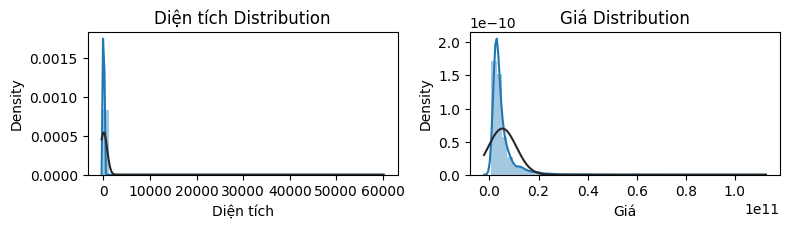

In [219]:
# Visualize the distribution of each variable.
plt.figure(figsize=(8, 10))
for i, j in enumerate(df.describe().columns):
    plt.subplot(5,2, i+1)
    sns.distplot(x=df[j], fit = stats.norm)
    plt.xlabel(j)
    plt.title('{} Distribution'.format(j))
    plt.tight_layout()
plt.show()


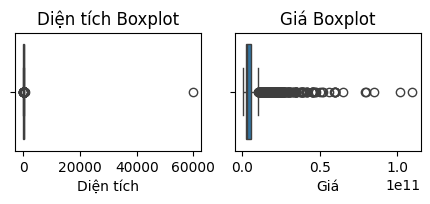

In [220]:
# Visualize the boxplot of each variable.
plt.figure(figsize=(11, 7))
for i, j in enumerate(df.describe().columns):
    plt.subplot(4,5, i+1)
    sns.boxplot(x=df[j])
    plt.title('{} Boxplot'.format(j))
    plt.tight_layout()

plt.show()

In [221]:
from scipy.stats.mstats import winsorize

# Áp dụng Winsorization ở mức 5% cho cả hai cột
df['Diện tích'] = winsorize(df['Diện tích'], limits=[0.05, 0.05])
df['Giá'] = winsorize(df['Giá'], limits=[0.05, 0.05])

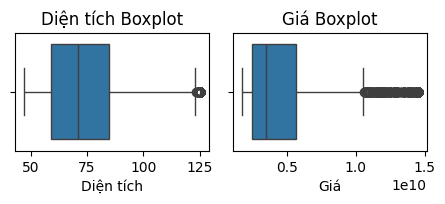

In [222]:
# Visualize the boxplot of each variable.
plt.figure(figsize=(11, 7))
for i, j in enumerate(df.describe().columns):
    plt.subplot(4,5, i+1)
    sns.boxplot(x=df[j])
    plt.title('{} Boxplot'.format(j))
    plt.tight_layout()

plt.show()

# ***`Log Transfromation`***

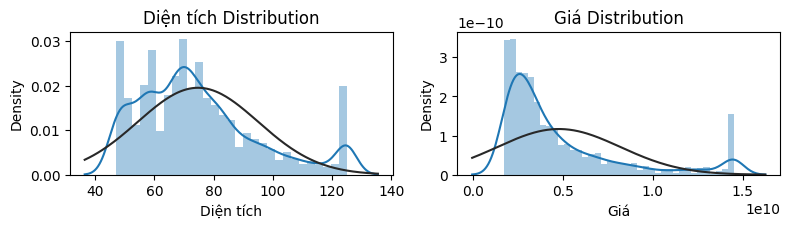

In [223]:
# Visualize the distribution of each variable.
plt.figure(figsize=(8, 10))
for i, j in enumerate(df.describe().columns):
    plt.subplot(5,2, i+1)
    sns.distplot(x=df[j], fit = stats.norm)
    plt.xlabel(j)
    plt.title('{} Distribution'.format(j))
    plt.tight_layout()
plt.show()


In [224]:
df[['Diện tích', 'Giá']] = df[['Diện tích', 'Giá']].apply(lambda x: np.log(x + 1))

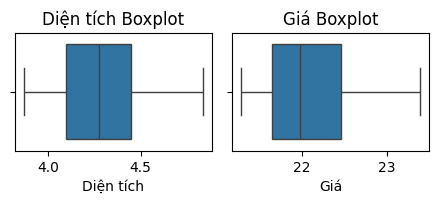

In [225]:
# Visualize the boxplot of each variable.
plt.figure(figsize=(11, 7))
for i, j in enumerate(df.describe().columns):
    plt.subplot(4,5, i+1)
    sns.boxplot(x=df[j])
    plt.title('{} Boxplot'.format(j))
    plt.tight_layout()

plt.show()

# ***`Label encoder`***

In [226]:
df.head(2)

,Quận,Phòng ngủ,Phòng tắm,Diện tích,Tình hình nội thất,Loại chủ quyền,Tình trạng sử dụng,Giá
0,Quan 9,>= 3 phòng,>= 3 phòng,4.653960,Đay đu noi that,Sổ hồng,Dang o,22.481124
1,Quan 2,Hai phòng,Hai phòng,4.442651,Noi that co ban,HĐ Mua bán,Nha Trong,23.397414


In [227]:
# Giả sử bạn có nhiều biến phân loại
encoder = LabelEncoder()

categorical_columns = ['Quận', 'Phòng ngủ', 'Phòng tắm', 'Tình hình nội thất', 'Loại chủ quyền', 'Tình trạng sử dụng']
for col in categorical_columns:
    df[col] = encoder.fit_transform(df[col])

In [228]:
df.head(2)

,Quận,Phòng ngủ,Phòng tắm,Diện tích,Tình hình nội thất,Loại chủ quyền,Tình trạng sử dụng,Giá
0,18,0,0,4.653960,2,2,0,22.481124
1,11,1,1,4.442651,1,0,1,23.397414


# ***`Standard Scaler`***

In [229]:
features_to_scale = ['Diện tích', 'Giá']
scaler = StandardScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# ***`Multicollinearity`***

In [230]:
df_final = df

In [231]:
from sklearn.utils import shuffle
df_final = shuffle(df_final, random_state=42).reset_index(drop=True)

In [232]:
# Chuẩn bị dữ liệu
X = df_final.drop('Giá', axis=1)
y = df_final['Giá']

In [233]:
# Tính VIF cho từng biến
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

              Feature        VIF
0                Quận   3.701973
1           Phòng ngủ   8.875329
2           Phòng tắm  11.415372
3           Diện tích   2.462832
4  Tình hình nội thất   3.673411
5      Loại chủ quyền   1.521931
6  Tình trạng sử dụng   5.946995


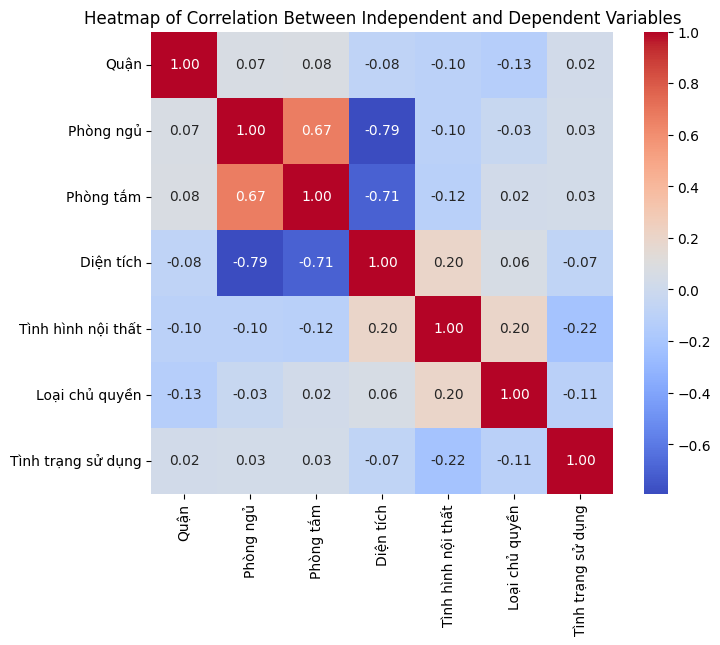

In [234]:
# Calculate correlation matrix
correlation_matrix = X.corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True, square=True, fmt=".2f")
plt.title("Heatmap of Correlation Between Independent and Dependent Variables")
plt.show()

# ***`Linear Regression`***

In [235]:
X

,Quận,Phòng ngủ,Phòng tắm,Diện tích,Tình hình nội thất,Loại chủ quyền,Tình trạng sử dụng
0,17,1,1,-0.063154,2,0,1
1,15,2,2,-1.403230,1,0,1
2,10,1,2,-0.860767,0,0,1
3,18,2,2,-1.327770,1,0,1
4,15,1,1,-1.646926,1,2,1
...,...,...,...,...,...,...,...
6777,18,0,1,1.174382,2,2,1
6778,1,1,1,0.153597,0,0,1
6779,20,1,1,-0.063154,1,2,1
6780,17,0,1,1.856640,2,0,1


In [236]:
X = X.drop(columns = ['Phòng tắm'])

In [237]:
# X = scaled_df[['Phòng ngủ', 'Phòng tắm', 'Diện tích', 'Quận_encoded', 'Tình hình nội thất_encoded', 'Loại chủ quyền_encoded', 'Tình trạng sử dụng_encoded', 'Hướng nhà_encoded']]
# y = scaled_df['Giá']

# Chia dữ liệu theo tỷ lệ 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Kiểm tra kích thước của tập huấn luyện và tập kiểm tra
print("Kích thước tập huấn luyện:", X_train.shape[0])
print("Kích thước tập kiểm tra:", X_test.shape[0])

# Thêm hằng số vào biến đầu vào
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Tạo mô hình OLS
model = sm.OLS(y_train, X_train)

# Huấn luyện mô hình
results = model.fit()

# In ra tóm tắt kết quả mô hình
print(results.summary())

# Dự đoán giá trị cho tập kiểm tra
y_pred = results.predict(X_test)

# Đánh giá mô hình bằng MSE, MAE, và RMSE
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

# In ra kết quả đánh giá
print("MSE:", mse)
print("MAE:", mae)
print("RMSE:", rmse)

Kích thước tập huấn luyện: 5425
Kích thước tập kiểm tra: 1357
                            OLS Regression Results                            
Dep. Variable:                    Giá   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     1025.
Date:                Fri, 01 Nov 2024   Prob (F-statistic):               0.00
Time:                        09:21:59   Log-Likelihood:                -5687.5
No. Observations:                5425   AIC:                         1.139e+04
Df Residuals:                    5418   BIC:                         1.144e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

# ***`K-Fold`***

In [238]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

model = LinearRegression()

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

mse_scores = []
mae_scores = []
rmse_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Tính MSE, MAE và RMSE
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)

# In kết quả
for i in range(k):
    print(f"Fold {i+1}: MSE = {mse_scores[i]:.4f}, MAE = {mae_scores[i]:.4f}, RMSE = {rmse_scores[i]:.4f}")

print("MSE trung bình:", np.mean(mse_scores))
print("MAE trung bình:", np.mean(mae_scores))
print("RMSE trung bình:", np.mean(rmse_scores))

Fold 1: MSE = 0.4488, MAE = 0.5154, RMSE = 0.6699
Fold 2: MSE = 0.4784, MAE = 0.5412, RMSE = 0.6916
Fold 3: MSE = 0.4911, MAE = 0.5467, RMSE = 0.7008
Fold 4: MSE = 0.4749, MAE = 0.5412, RMSE = 0.6891
Fold 5: MSE = 0.4657, MAE = 0.5329, RMSE = 0.6824
MSE trung bình: 0.4717725620972571
MAE trung bình: 0.5354636028771174
RMSE trung bình: 0.6867800188446197
